# Install dependencies

In [144]:
%pip install scikit-image
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Import main packages

In [145]:
from PIL import Image
import numpy as np 
import skimage
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual

# Load a cube

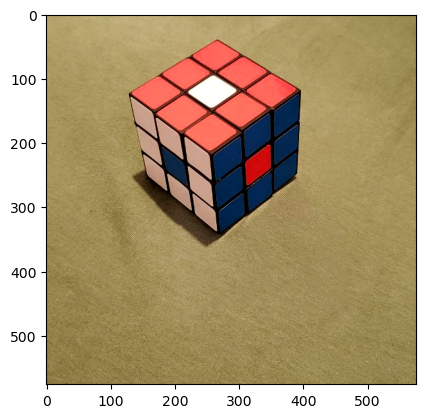

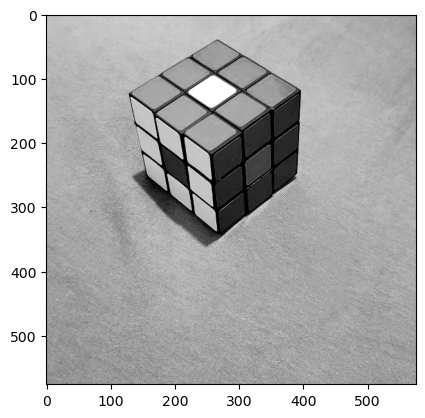

In [165]:

from skimage.color import rgb2gray, rgb2xyz
from skimage.exposure import adjust_sigmoid
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist, rescale_intensity, adjust_sigmoid

def crop_at_center(image):
    width, height, _ = image.shape
    size = min([height, width]) * 0.3

    return image[
        round(width/2 - size): round(width/2 + size),
        round(height/2 - size): round(height/2 + size),
    ]

cube = skimage.io.imread("test_images/cube_7.jpg")
cube = crop_at_center(cube)

p2, p98 = np.percentile(cube, (2, 98))
cube = rescale_intensity(cube, in_range=(p2, p98))

grey_cube = 1 - rgb2gray(cube)

plt.imshow(cube)
plt.show()

plt.imshow(grey_cube, cmap="Greys")
plt.show()

In [147]:
from skimage.feature import canny
from skimage.morphology import binary_dilation

def show_borders(sigma, dilation):
    borders = canny(grey_cube, sigma)
    
    kernel = np.ones(shape=(dilation, dilation))
    dilated = binary_dilation(borders, kernel)

    plt.imshow(dilated, cmap="Greys")
    plt.show()

interact(show_borders, sigma=(0, 10, 0.1), dilation=(1, 10))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0), IntSlider(value=5, description='d…

<function __main__.show_borders(sigma, dilation)>

In [148]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.segmentation import slic, mark_boundaries, watershed, felzenszwalb
from skimage.filters import sobel

def segment_by_color(n_segments, compactness, sigma):
    segments = slic(cube, n_segments=n_segments, compactness=compactness, sigma=sigma)
    plt.imshow(segments, interpolation="nearest")
    plt.show()

interact(segment_by_color, n_segments=(0, 100), compactness=(0.1, 1), sigma=(0, 3, 0.1))

# def segment_by_color(scale, sigma, min_size):
#     segments = felzenszwalb(cube, scale=scale, sigma=sigma, min_size=min_size)
#     plt.imshow(segments, interpolation="nearest")
#     plt.show()

# interact_manual(segment_by_color, scale=(0, 100), sigma=(0.1, 1), min_size=50)

interactive(children=(IntSlider(value=50, description='n_segments'), FloatSlider(value=0.55, description='comp…

<function __main__.segment_by_color(n_segments, compactness, sigma)>

In [217]:
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

def extract_lines(sigma, line_length, line_width, line_gap):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)

    h_angles = np.arange(0, np.pi, 0.01)

    lines = probabilistic_hough_line(dilated, theta=h_angles, threshold=300, line_length=line_length, line_gap=line_gap)

    plt.imshow(cube, alpha=0.4)
    for p0, p1 in lines:
        x = [p0[0], p1[0]]
        y = [p0[1], p1[1]]
        plt.plot(x, y, linewidth=line_width)
    plt.show()

interact(extract_lines, sigma=(0, 5, 0.1), line_length=(0, 500), line_width=(0, 10), line_gap=(0, 1000))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=250, description='…

<function __main__.extract_lines(sigma, line_length, line_width, line_gap)>

In [155]:
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from scipy.cluster.vq import kmeans
from skimage.segmentation import slic

def extract_lines(sigma, min_distance, min_angle, line_width):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)

    bla = hough_line_peaks(*hough_line(dilated), num_peaks=50, min_distance=min_distance, min_angle=min_angle)
    print(bla[1])

    plt.imshow(dilated, cmap="Greys")
    for _, angle, dist in zip(*bla):
        slope = np.tan(angle + np.pi/2)
        x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
        plt.axline((x0, y0), slope=slope, color="darkred")

    # print(np.degrees(bla[1]))
    # print(kmeans(np.degrees(bla[1]), k_or_guess=3))

    # mean_angles, _ = kmeans(bla[1], k_or_guess=3)
    # for angle in mean_angles:
    #     slope = np.tan(angle + np.pi/2)
    #     plt.axline((400, 400), slope=slope, color="darkblue")


    # print(borders.shape)
    # print(hough_space.shape)
    # print(angles.shape)
    # print(distances.shape)



    # plt.imshow(np.log(1 + hough_space), aspect='auto', cmap="inferno")
    plt.show()

    # plt.imshow(lines)
    # plt.show()
    # for p0, p1 in lines:
    #     x = [p0[0], p1[0]]
    #     y = [p0[1], p1[1]]
    #     plt.plot(x, y, linewidth=line_width)
    # plt.show()

interact(extract_lines, sigma=(0, 5, 0.1), min_distance=(0, 200), min_angle=(0,200), line_width=(1, 10))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=100, description='…

<function __main__.extract_lines(sigma, min_distance, min_angle, line_width)>

# extract cube mask

In [166]:
from skimage.feature import canny
from skimage.morphology import binary_dilation
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_opening, convex_hull_image, binary_dilation

def extract_cube(sigma, dilation):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(dilation, dilation))

    filled_cube = convex_hull_image(borders)
    filled_cube = binary_opening(filled_cube, kernel)

    plt.imshow(filled_cube, cmap="Greys")
    plt.imshow(borders, cmap="inferno", alpha=0.5)
    plt.show()

interact(extract_cube, sigma=(0, 10, 0.1), dilation=(1, 10))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0), IntSlider(value=5, description='d…

<function __main__.extract_cube(sigma, dilation)>

# Extract squares

In [167]:
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from scipy.cluster.vq import kmeans
from skimage.segmentation import slic
from itertools import pairwise, chain, combinations


def line_intersection(dist0, angle0, dist1, angle1):
    slope0 = np.tan(angle0 + np.pi/2)
    x0, y0 = dist0 * np.array([np.cos(angle0), np.sin(angle0)])
    bias0 = y0 - slope0 * x0

    slope1 = np.tan(angle1 + np.pi/2)
    x1, y1 = dist1 * np.array([np.cos(angle1), np.sin(angle1)])
    bias1 = y1 - slope1 * x1

    x = (bias1 - bias0) / (slope0 - slope1)
    y = x * slope0 + bias0
    return x, y

def extract_square(da0, da1, da2, da3):
    p0 = line_intersection(*da0, *da2)
    p1 = line_intersection(*da1, *da2)
    p2 = line_intersection(*da1, *da3)
    p3 = line_intersection(*da0, *da3)
    return [p0, p1, p2, p3]

def estract_squares(sigma, min_distance, min_angle, line_width):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)

    hspace, angles, distances = hough_line_peaks(*hough_line(dilated), num_peaks=50, min_distance=min_distance, min_angle=min_angle)
    means, _ = kmeans(angles, k_or_guess=2)
    
    directions = [
        [],
        [],
        [],
    ]

    for angle, dist in zip(angles, distances):
        diff = np.abs(means - angle)
        index = np.argmin(diff)
        directions[index].append((dist, angle))
    
    for direction in directions:
        direction.sort()

    plt.imshow(dilated, cmap="Greys")
    for dist, angle in chain(*directions):
        slope = np.tan(angle + np.pi/2)
        x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
        plt.axline((x0, y0), slope=slope)

    # for v0, v1 in pairwise(directions[0]):
    #     for h0, h1 in pairwise(directions[1]):
    #         points = extract_square(v0, v1, h0, h1)
    #         x_list = [p[0] for p in points]
    #         y_list = [p[1] for p in points]
    #         plt.fill(x_list, y_list, alpha=0.5)

    plt.show()

interact(estract_squares, sigma=(0, 5, 0.1), min_distance=(0, 200), min_angle=(0,200), line_width=(1, 10))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=100, description='…

<function __main__.estract_squares(sigma, min_distance, min_angle, line_width)>

# Transformada Hough Paralelograms

In [240]:
from collections import defaultdict


def divide_in_chunks(chunk_size):
    chunks = dict()
    for i in range(0, cube.shape[0], chunk_size):
        for j in range(0, cube.shape[1], chunk_size):
            chunk = cube[i:i+chunk_size, j:j+chunk_size]

            if chunk.shape[0] != chunk_size:
                continue

            if chunk.shape[1] != chunk_size:
                continue

            chunks[i, j] = chunk
    
    w, h, *rest = cube.shape
    combined_shape = (
        w - w % chunk_size,
        h - h % chunk_size,
        *rest
    )
            
    return chunks, combined_shape

def extract_lines(chunk, sigma=2, line_width=1):
    grey_chunk = 1 - rgb2gray(chunk)
    borders = canny(grey_chunk, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)
    hspace, angles, distances = hough_line_peaks(*hough_line(dilated), num_peaks=4)
    return list(zip(distances, angles))

def bla(chunk_size):
    chunks, combined_shape = divide_in_chunks(chunk_size)

    reconstructed = np.zeros(combined_shape, dtype=int)
    for (i, j), chunk in chunks.items():
        reconstructed[i:i+chunk_size, j:j+chunk_size] = chunk
        x = [i, i+chunk_size, i+chunk_size, i]
        y = [j, j, j+chunk_size, j+chunk_size]
        plt.plot(x, y, color="black")

    for (i, j), chunk in chunks.items():
        lines = extract_lines(chunk)
        for dist, angle in lines:
            slope = np.tan(angle + np.pi/2)
            x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])

            x = [x0+j, x0 + j + chunk_size]
            y = [y0+i, y0 + i + chunk_size * slope]
            plt.plot(x, y)
            # plt.axline((x0+j, y0+i), slope=slope)

    plt.imshow(cube)
    plt.show()

    plt.imshow(reconstructed)
    plt.show()
    # print(reconstructed.shape)        

interact(bla, chunk_size=(0, 100))

interactive(children=(IntSlider(value=50, description='chunk_size'), Output()), _dom_classes=('widget-interact…

<function __main__.bla(chunk_size)>